In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicta-1-0-predict-the-unpredictable/submission_key.csv
/kaggle/input/predicta-1-0-predict-the-unpredictable/sample_submission.csv
/kaggle/input/predicta-1-0-predict-the-unpredictable/historical_weather.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
submission_key= pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/submission_key.csv')

submission_key.head(6)

,submission_ID,city_id,date
0,1,C001,2019-01-01
1,2,C001,2019-01-02
2,3,C001,2019-01-03
3,4,C001,2019-01-04
4,5,C001,2019-01-05
5,6,C001,2019-01-06


In [4]:
historical_w= pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/historical_weather.csv')

historical_w.head(6)
#historical_w.info()
#historical_w.shape ---> (182338, 9)

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0
5,C001,2014-01-06,9.1,5.7,14.7,NaN,NaN,156.0,5.7


In [5]:
# Check for missing values
historical_w.isnull().sum()
# Handle missing values (e.g., by filling or dropping)
historical_w.fillna(method='ffill', inplace=True)
historical_w.isnull().sum()

/tmp/ipykernel_19/3142546144.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_w.fillna(method='ffill', inplace=True)


city_id                  0
date                     0
avg_temp_c               0
min_temp_c               0
max_temp_c               0
precipitation_mm        33
snow_depth_mm         5452
avg_wind_dir_deg         0
avg_wind_speed_kmh       0
dtype: int64

In [6]:
# Convert date column to datetime
historical_w['date'] = pd.to_datetime(historical_w['date'])
# Extract year, month, and day for further feature engineering
historical_w['year'] = historical_w['date'].dt.year
historical_w['month'] = historical_w['date'].dt.month
historical_w['day'] = historical_w['date'].dt.day

# Create additional features if necessary
historical_w['dayofyear'] = historical_w['date'].dt.dayofyear

# Example: Rolling average temperature for the past week
historical_w['rolling_avg_temp'] = historical_w.groupby('city_id')['avg_temp_c'].transform(lambda x: x.rolling(window=7).mean())

# Check the preprocessing results
historical_w.head()
historical_w.fillna(method='ffill', inplace=True)
historical_w.isnull().sum()

/tmp/ipykernel_19/2549262604.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_w.fillna(method='ffill', inplace=True)


city_id                  0
date                     0
avg_temp_c               0
min_temp_c               0
max_temp_c               0
precipitation_mm        33
snow_depth_mm         5452
avg_wind_dir_deg         0
avg_wind_speed_kmh       0
year                     0
month                    0
day                      0
dayofyear                0
rolling_avg_temp         6
dtype: int64

# Model Building and Training

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Prepare the data for model training
X = historical_w[['year', 'month', 'day', 'dayofyear', 'rolling_avg_temp']]
y = historical_w['avg_temp_c']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Check for Null values in X_train and X_val
#print(X_train.isnull().sum())
#print(X_val.isnull().sum())

# Fill NaN values with the mean of the column
X_train.fillna(X_train.mean(), inplace=True)
X_val.fillna(X_val.mean(), inplace=True)

print(X_train.isnull().sum())
print(X_val.isnull().sum())


# Train a model (Gradient Boosting Regressor as an example)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Validate the model
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')


year                0
month               0
day                 0
dayofyear           0
rolling_avg_temp    0
dtype: int64
year                0
month               0
day                 0
dayofyear           0
rolling_avg_temp    0
dtype: int64
Mean Squared Error: 4.6645707392364


# Prediction

In [8]:
# Prepare the data for prediction
first_week_2019 = pd.date_range(start='2019-01-01', end='2019-01-07')
predict_data = pd.DataFrame({'date': first_week_2019})
predict_data['year'] = predict_data['date'].dt.year
predict_data['month'] = predict_data['date'].dt.month
predict_data['day'] = predict_data['date'].dt.day
predict_data['dayofyear'] = predict_data['date'].dt.dayofyear

print(predict_data)

predictions = []





        date  year  month  day  dayofyear
0 2019-01-01  2019      1    1          1
1 2019-01-02  2019      1    2          2
2 2019-01-03  2019      1    3          3
3 2019-01-04  2019      1    4          4
4 2019-01-05  2019      1    5          5
5 2019-01-06  2019      1    6          6
6 2019-01-07  2019      1    7          7


In [9]:
for city_id in submission_key['city_id'].unique():
    city_data = historical_w[historical_w['city_id'] == city_id]
    city_data = pd.concat([city_data, predict_data], ignore_index=True)
    city_data['rolling_avg_temp'] = historical_w['avg_temp_c'].rolling(window=7).mean()
    
    X_pred = city_data[['year', 'month', 'day', 'dayofyear', 'rolling_avg_temp']].tail(7)
    y_pred = model.predict(X_pred)

# Replace null values with zero in the entire DataFrame
#city_data.fillna(0, inplace=True)
    
    for date, temp in zip(first_week_2019, y_pred):
        submission_id = submission_key[(submission_key['city_id'] == city_id) & (submission_key['date'] == date.strftime('%Y-%m-%d'))]['submission_ID'].values[0]
        predictions.append({'submission_ID': submission_id, 'avg_temp_c': temp})
(city_data.tail(14))

# Create the submission dataframe
submission_df = pd.DataFrame(predictions)
#print(submission_df[0:700])

# Save submission to CSV
submission_df.to_csv('sample_submission.csv', index=False)
#!rm sample_submission.csv

In [10]:
submission_df
#submission_df.min()

,submission_ID,avg_temp_c
0,1,11.604942
1,2,12.242900
2,3,12.869708
3,4,13.583087
4,5,14.900965
...,...,...
695,696,11.935637
696,697,12.116014
697,698,12.737090
698,699,13.386148


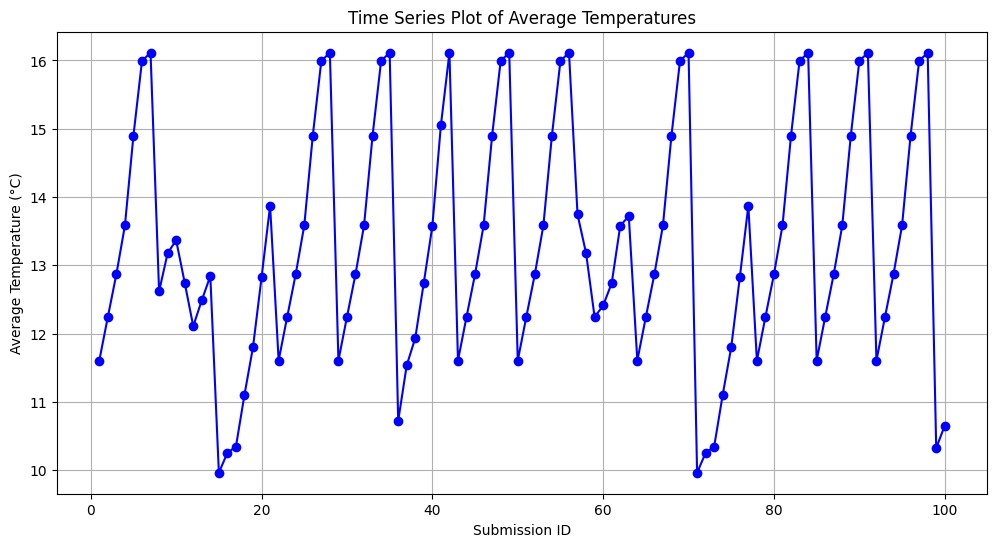

In [11]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(submission_df['submission_ID'].head(100), submission_df['avg_temp_c'].head(100), marker='o', linestyle='-', color='b')
plt.title('Time Series Plot of Average Temperatures')
plt.xlabel('Submission ID')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.show()